# Aula 4

## Vídeo 4.1

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [ ]:
credenciais = service_account.Credentials.from_service_account_file('chave_teste.json')

In [ ]:
project_id = 'curso-teste-351120'

In [ ]:
cliente = bigquery.Client(credentials=credenciais, project=project_id)

In [ ]:
trabalho_busca = cliente.query("""
SELECT *
FROM `terremotos_brasil.centro_sismo2`;
""")

In [ ]:
trabalho_busca.result().to_dataframe()

In [ ]:
df = trabalho_busca.result().to_dataframe()

In [ ]:
df.head()

## Vídeo 4.2

In [ ]:
trabalho_busca = cliente.query("""
SELECT Time, Latitude, Longitude, Depth_km, Magtype, Magnitude
FROM `terremotos_brasil.centro_sismo2`
WHERE Magtype IS NOT NULL;
""")

In [ ]:
trabalho_busca.result().to_dataframe()

In [ ]:
schema = [
    bigquery.SchemaField("Time", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("Latitude","FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("Longitude","FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("Depth_km", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("Magtype","STRING", mode="NULLABLE"),
    bigquery.SchemaField("Magnitude", "FLOAT", mode="NULLABLE")
]

In [ ]:
table_id = "curso-teste-351120.terremotos_brasil.sismos_do_dia"

In [ ]:
tabela = bigquery.Table(table_id,schema=schema)

In [ ]:
tabela = cliente.create_table(tabela)

In [ ]:
from datetime import datetime
import pytz
import pandas as pd

In [ ]:
pytz.country_timezones['br']

In [ ]:
pytz.timezone('America/Manaus').localize(datetime(2022, 9,14)).astimezone(pytz.utc)

In [ ]:
linhas = [
    {
     'Time':pytz.timezone('America/Manaus').localize(datetime(2022, 9,14)).astimezone(pytz.utc),
     'Latitude':-59.04,
     'Longitude':-16.70,
     'Depth_km': 0.0,
     'Magtype':'mb',
     'Magnitude': 3.5},
     {
     'Time':pytz.timezone('America/Manaus').localize(datetime(2022, 9,2)).astimezone(pytz.utc),
     'Latitude':-52.95,
     'Longitude':-16.48,
     'Depth_km': 0.0,
     'Magtype':'mR',
     'Magnitude': 2.8  
     },
]

In [ ]:
linhas

In [ ]:
dataframe = pd.DataFrame(linhas)

In [ ]:
dataframe

In [ ]:
trabalho = cliente.load_table_from_dataframe(
    dataframe, table_id
)
# https://cloud.google.com/bigquery/docs/samples/bigquery-load-table-dataframe

In [ ]:
trabalho.result()

In [ ]:
trabalho = cliente.load_table_from_dataframe(
    dataframe, 'curso-teste-351120.terremotos_brasil.centro_sismo2'
)

In [ ]:
trabalho_busca = cliente.query("""
SELECT *
FROM `terremotos_brasil.centro_sismo2`
WHERE Latitude = -52.95 AND Longitude=-16.48
""")

In [ ]:
trabalho_busca.result().to_dataframe()

In [ ]:
trabalho = cliente.query("""
UPDATE curso-teste-351120.terremotos_brasil.centro_sismo2 SET
MagAuthor = 'Allan', _EventID = 'Alura1'
WHERE Latitude=-52.95 AND Longitude=-16.48
""")

In [ ]:
trabalho = cliente.query("""
DELETE FROM curso-teste-351120.terremotos_brasil.centro_sismo2
WHERE Latitude = -59.04 AND Longitude = -16.70
""")

# Aula 5

## Vídeo 5.1

### Mapa mundi

In [ ]:
trabalho_busca = cliente.query("""
SELECT latitude, longitude, intensity
FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
WHERE latitude IS NOT NULL AND longitude IS NOT NULL AND intensity IS NOT NULL AND country IS NOT NULL
""")

In [ ]:
df_mundi = trabalho_busca.result().to_dataframe()

In [ ]:
df_mundi.head()

In [ ]:
import folium

In [ ]:
mapa_mundi = folium.Map(location=[43.03208,-0.89221],zoom_start=2,tiles='Stamen Terrain')
mapa_mundi

In [ ]:
grupo_terremotos = folium.map.FeatureGroup()

In [ ]:
for lat, lon, in zip(df_mundi['latitude'],df_mundi['longitude']):
  grupo_terremotos.add_child(
      folium.CircleMarker([lat,lon],radius=2)
  )
mapa_mundi.add_child(grupo_terremotos)

In [ ]:
from folium import plugins

In [ ]:
mapa_calor = folium.Map(location=[43.03208,-0.89221],zoom_start=2,tiles='Cartodb dark_matter')

plugins.HeatMap(df_mundi[['latitude','longitude']]).add_to(mapa_calor)
mapa_calor


### Escala de intensidade de Mercalli modificada

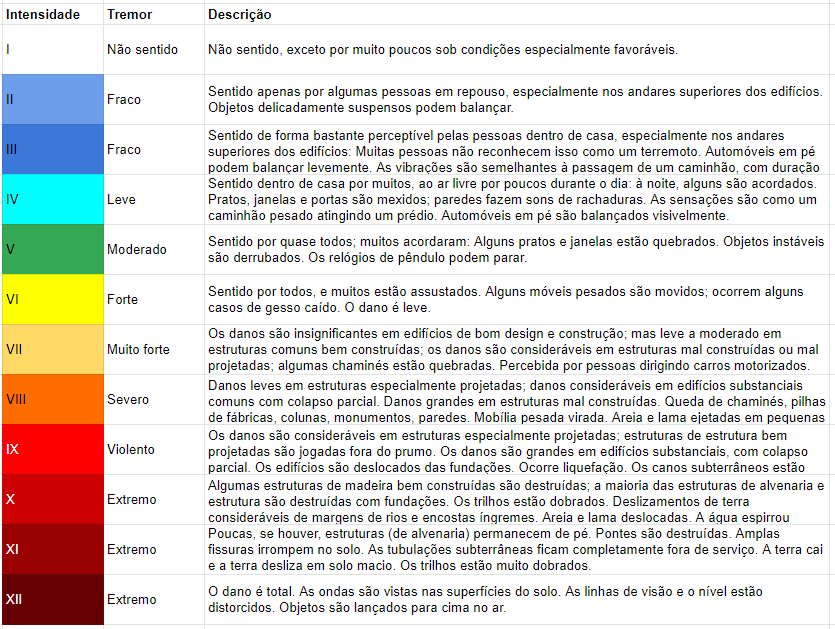

In [ ]:
mapa_intensidade = folium.Map(location=[4.534399,-53.067964],zoom_start=5,tiles='Stamen Terrain')
grupo_terremotos = folium.map.FeatureGroup()
for lat, lon,intensi in zip(df_mundi['latitude'],df_mundi['longitude'],df_mundi['intensity']):
  grupo_terremotos.add_child(
      folium.Marker([lat,lon],icon=folium.Icon(color='red',icon_color='yellow',icon='warning-sign'), popup=intensi)
  )
mapa_intensidade.add_child(grupo_terremotos)

## Vídeo 5.2

https://cloud.google.com/bigquery/docs/reference/standard-sql/mathematical_functions

https://www.usgs.gov/programs/earthquake-hazards/earthquake-magnitude-energy-release-and-shaking-intensity#:~:text=The%20energy%20release%20can%20also,w%20is%20the%20moment%20magnitude.


Conversão para energia liberada por um terremoto

$ E = e^{5.24+1.44M_W} $


In [ ]:
trabalho_busca = cliente.query("""
SELECT Time, Latitude, Longitude, Depth_km, Magtype, Magnitude, 
ROUND(EXP(5.24 + 1.44*Magnitude),2) AS Energy, ST_GEOGPOINT(Longitude, Latitude) AS Pontos,
CONCAT(Latitude,',',Longitude) AS LatLon
FROM `terremotos_brasil.centro_sismo2` 
WHERE Magtype IS NOT NULL AND Longitude > -74.10 AND Latitude < 4.42 AND Longitude < -7.26 AND Latitude > -34.03;
""")

In [ ]:
trabalho_busca.result().to_dataframe()

In [ ]:
df_brasil=trabalho_busca.result().to_dataframe()

In [ ]:
trabalho_busca = cliente.query("""
WITH texto AS (
SELECT 'Terremoto1|teste' as id
UNION ALL SELECT 'Terremoto2|Mw' as id
UNION ALL SELECT 'Terremoto3|mb' as id)

SELECT
  REGEXP_EXTRACT(id, r'^[a-zA-Z0-9_]+')
  AS id
FROM texto
""")
trabalho_busca.result().to_dataframe()

In [ ]:
mapa_brasil = folium.Map(location=[-15.77,-47.94],zoom_start=4,tiles='Stamen Terrain')
grupo_terremotos = folium.map.FeatureGroup()
for lat, lon, in zip(df_brasil['Latitude'],df_brasil['Longitude']):
  grupo_terremotos.add_child(
      folium.CircleMarker([lat,lon],radius=2)
  )
mapa_brasil.add_child(grupo_terremotos)

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent='geoapiExercises')

In [ ]:
location = geolocator.reverse(df_brasil['LatLon'][20])

In [ ]:
location.raw['address']['state']

In [ ]:
bloco1 = df_brasil['LatLon'][0:10].apply(geolocator.geocode)

In [ ]:
bloco1

https://gpereira.carto.com/tables/brasil_estados/public

In [ ]:
df_sp = df_brasil.query('Longitude > -53.08 and Longitude < -44.16 and Latitude > -25.31 and Latitude < -19.98')

In [ ]:
df_sp.shape

In [ ]:
df_sp

In [ ]:
df_sp['Energy'].mean()

In [ ]:
geo = r'/content/brasil_estados.geojson'

In [ ]:
mapa_brasil = folium.Map(location=[-15.77,-47.94],zoom_start=4,tiles='Stamen Terrain')

In [ ]:
folium.GeoJson(geo).add_to(mapa_brasil)

In [ ]:
mapa_brasil

https://www.distancelatlong.com/country/brazil/

In [ ]:
import pandas as pd

In [ ]:
df_energia_media = pd.DataFrame()

In [ ]:
df_energia_media['nome_uf'] = ['Acre','Alagoas','Amap','Amazonas','Bahia','Cear','Esprito Santo',
                               'Gois','Maranho','Mato Grosso','Mato Grosso do Sul',
                               'Minas Gerais','Par','Paraba','Paran','Pernambuco',
                               'Piau','Rio de Janeiro','Rio Grande do Norte','Rio Grande do Sul',
                               'Rondnia','Roraima','Santa Catarina','So Paulo','Sergipe',
                               'Tocantins','DF']

In [ ]:
import numpy as np

In [ ]:
np.zeros(27)

In [ ]:
df_energia_media['energia'] = np.zeros(27)

In [ ]:
df_energia_media['energia'][23] = df_sp['Energy'].mean()

In [ ]:
df_energia_media

In [ ]:
folium.Choropleth(
    geo_data=geo,
    data=df_energia_media,
    columns=['nome_uf','energia'],
    key_on='properties.nome_uf'
).add_to(mapa_brasil)

In [ ]:
mapa_brasil

# Aula 6

In [ ]:
df_brasil.head()

In [ ]:
trabalho_busca = cliente.query("""
SELECT Time, Latitude, Longitude, Depth_km, Magtype, Magnitude, 
ST_GEOGPOINT(Longitude, Latitude) AS Pontos,
FROM `terremotos_brasil.centro_sismo2` 
WHERE Magtype IS NOT NULL AND Longitude > -35.80 AND Latitude < -5.00 AND Longitude < -35.00 AND Latitude > -5.80;
""")

In [ ]:
df_falha=trabalho_busca.result().to_dataframe()

In [ ]:
mapa_falha = folium.Map(location=[-5.33,-35.45],zoom_start=10,tiles='Stamen Terrain')
grupo_terremotos = folium.map.FeatureGroup()
for lat, lon, in zip(df_falha['Latitude'],df_falha['Longitude']):
  grupo_terremotos.add_child(
      folium.CircleMarker([lat,lon],radius=2)
  )
mapa_falha.add_child(grupo_terremotos)

In [ ]:
trabalho_busca = cliente.query("""
SELECT Latitude, Longitude, Pontos, ST_CLUSTERDBSCAN(Pontos,3000,3) OVER () AS cluster_num
FROM
  (SELECT Time, Latitude, Longitude, Depth_km, Magtype, Magnitude, 
    ST_GEOGPOINT(Longitude, Latitude) AS Pontos,
    FROM `terremotos_brasil.centro_sismo2` 
    WHERE Magtype IS NOT NULL AND Longitude > -35.80 AND Latitude < -5.00 AND Longitude < -35.00 AND Latitude > -5.80)

""")

In [ ]:
df_falha=trabalho_busca.result().to_dataframe()

In [ ]:
df_falha

In [ ]:
df_falha['cluster_num'].unique()

In [ ]:
df_falha0 = df_falha.query('cluster_num==0')
df_falha1 = df_falha.query('cluster_num==4')

In [ ]:
mapa_falha = folium.Map(location=[-5.33,-35.45],zoom_start=10,tiles='Stamen Terrain')
grupo_terremotos0 = folium.map.FeatureGroup()
for lat, lon, in zip(df_falha0['Latitude'],df_falha0['Longitude']):
  grupo_terremotos0.add_child(
      folium.CircleMarker([lat,lon],color='red',radius=1)
  )
grupo_terremotos1 = folium.map.FeatureGroup()
for lat, lon, in zip(df_falha1['Latitude'],df_falha1['Longitude']):
  grupo_terremotos0.add_child(
      folium.CircleMarker([lat,lon],color='yellow',radius=1)
  )
mapa_falha.add_child(grupo_terremotos)
mapa_falha.add_child(grupo_terremotos0)
mapa_falha.add_child(grupo_terremotos1)

https://noticias.uol.com.br/cotidiano/ultimas-noticias/2011/10/30/mais-de-20-anos-apos-terremoto-joao-camara-rn-volta-a-registrar-atividade-sismica-e-preocupa-populacao.htm